# **2022 ML FALL HW1: PM2.5 Prediction (Regression)**

Author: MLTAs

Methods:
* Training with all data
* Training config: mini-batch=512, optimizer=Adam, learning rate=0.1 (TODO: Change the config!)



# **Import Some Packages**

In [115]:
import numpy as np
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import random


os.getcwd()

seed = 9487
np.random.seed(seed)
random.seed(seed)

# **Download training data**


In [116]:
# !gdown --id "1Hfzrcm69QwdFvdeF0uASoQlcVxKw_hHy" --output "train.csv"s
# !gdown --id '1FXJztppYG9Q4b_4NHvcmPsc4o5obceWC' --output "test.csv"

# Incase the links above die, you can use the following instead.
#!gdown --id '11abE854Eyv4BA7qt5k8r_80sJ3KuOQUN' --output "train.csv"
# !gdown --id '1uod-Z4ztluXnuHtgUbm39nMudUKqXHMl' --output "test.csv"

# If the data is still missing, you can manually download it from kaggle, and upload the files under /content

# **Define function**

In [117]:
# Choose valid data by filter
def valid(x):
    # Total unvalid datas is 35
    global count
    dic = {
        'AMB_TEMP':0, 'CO':1, 'NO':2, 'NO2':3, 'NOx':4, 'O3':5,
        'PM10':6, 'WS_HR':7, 'RAINFALL':8, 'RH':9, 'SO2':10,
        'WD_HR':11, 'WIND_DIREC':12, 'WIND_SPEED':13, 'PM2.5':14}
    for i in range(len(x[0])):
        if x[dic['CO']][i] > 1.4 or x[dic['NO']][i] > 40 or x[dic['NO2']][i] > 55 or \
            x[dic['NOx']][i] > 75 or x[dic['O3']][i] > 120 or x[dic['PM10']][i] > 150 or \
            x[dic['RAINFALL']][i] > 30 or x[dic['SO2']][i] > 20 or x[dic['PM2.5']][i] > 65:
            count.append(i)
    count.reverse()
    for i in range(len(count)):
        for j in range(15):
            del x[j][count[i]]
    return np.array(x)

# Create your dataset
def parse2train_x(data, feats):
    x = []

    # Use data #0~#7 to predict #8 => Total data length should be decresased by 8.
    total_length = data.shape[1] - 8  # data.shape[1] == 5774
    
    for i in range(total_length):
        x_tmp = data[feats, i:i+8] # Use data #0~#7 to predict #8, data #1~#8 to predict #9, etc. Feats is row of data and i:i+8 is column of data
        x.append(x_tmp.reshape(-1,))
    
    # Total valid datas is 5739
    # x.shape: (n, 15, 8)
    x = np.array(x)
    return x

def parse2train_y(data, feats):
    y = []

    # Use data #0~#7 to predict #8 => Total data length should be decresased by 8.
    total_length = data.shape[1] - 8  # data.shape[1] == 5774
    
    for i in range(total_length):
        y_tmp = data[-1, i+8] # last column of (i+8)th row: PM2.5
        y.append(y_tmp)
    
    y = np.array(y)
    return y
    
def parse2test(data, feats):
    x = []
    for i in range(90):
        x_tmp = data[feats, 8*i:8*i+8]
        x.append(x_tmp.reshape(-1,))

    # x.shape: (n, 15, 8)
    x = np.array(x)
    return x

# Normalize data
def norm_data(data, norm_case, mean_arr=0, std_arr=0):
    dic_data_round = {
        0 : 1, 1 : 2, 2 : 1, 3 : 1, 4 : 1,
        5 : 1, 6 : 0, 7 : 1, 8 : 1, 9 : 0, 
        10 : 1, 11 : 0, 12 : 0, 13 : 1, 14 : 0
    }

    # Z-Score
    if norm_case == 0:
        train_data = data
        mean_arr = np.zeros(15)
        std_arr = np.zeros(15)

        for i in range(15):
            # Compute mean
            mean_temp = sum(train_data[i])
            mean_arr[i] = mean_temp / float(len(train_data[i]))
        
            # Compute std
            std_temp = 0
            for j in range(len(train_data[i])):
                std_temp += (train_data[i][j] - mean_arr[i])**2
            std_arr[i] = (std_temp / float((len(train_data[i] - 1))))**0.5

            # Create normalize data
            train_data[i] -= mean_arr[i]
            train_data[i] = np.round(train_data[i] / std_arr[i], dic_data_round[i]+1)
        return train_data, mean_arr, std_arr

    # Max-Min
    elif norm_case == 1:
        train_data = data
        for i in range(15):
            max_temp = max(train_data[i])
            min_temp = min(train_data[i])
            train_data[i] = np.round((data[i] - min_temp) / (max_temp - min_temp), dic_data_round[i]+1)
        return train_data, max_temp, min_temp
    
    # MaxAbs
    elif norm_case == 2:
        train_data = data
        for i in range(15):
            maxabs_temp = abs(max(train_data[i]))
            train_data[i] = np.round(train_data[i] / maxabs_temp, dic_data_round[i]+1)
        return train_data, maxabs_temp

    # RobustScaler
    elif norm_case == 3:
        train_data = data

        return train_data

    # Normalize Testing Data
    elif norm_case == 4:
        test_data = data
        for i in range(15):
            test_data[i] -= mean_arr[i]
            test_data[i] = np.round(test_data[i] / std_arr[i], dic_data_round[i]+1)
        return test_data

    else:
        print('No define the normalize method, please check again')
        return data

# Visualize data
def visul_data(data, path, norm_type=0):
    dic_data_title = {
        0 : 'AMB_TEMP', 1 : 'CO', 2 : 'NO', 3 : 'NO2', 4 : 'NOx',
        5 : 'O3', 6 : 'PM10', 7 : 'WS_HR', 8 : 'RAINFALL', 9 : 'RH',
        10 : 'SO2', 11 : 'WD_HR', 12 : 'WIND_DIREC', 13 : 'WIND_SPEED', 14 : 'PM2.5'
    }
    dic_norm_type = {
        0:'_zscore_norm.png',
        1:'_maxmin_norm.png',
        2:'_maxabs_norm.png',
        3:'_robust_norm.png'
    }

    for i in range(15):
        j = np.arange(len(data[i]))
        plt.scatter(j, data[i])
        plt.xlabel('i-th data')
        plt.ylabel(dic_data_title[i])
        plt.savefig(path + dic_data_title[i] + dic_norm_type[norm_type])
        plt.show()


In [118]:
# TODO: Implement 2-nd polynomial regression version for the report.
def minibatch(x, y, config):
  
    # Randomize the data in minibatch
    index = np.arange(x.shape[0])
    np.random.shuffle(index)
    x = x[index]
    y = y[index]
    
    # Initialization
    batch_size = config.batch_size
    lr = config.lr
    lam = config.lam
    epoch = config.epoch

    beta_1 = np.full(x[0].shape, 0.9).reshape(-1, 1)
    beta_2 = np.full(x[0].shape, 0.99).reshape(-1, 1)
    # Linear regression: only contains two parameters (w, b).
    w = np.full(x[0].shape, 0.1).reshape(-1, 1)
    w2 = np.full(x[0].shape, 0.1).reshape(-1, 1)    # Implement 2-nd polynomial regression
    bias = 0.1

    # with open('./model/weight_3.27011.pickle', 'rb') as f:
    #     w = pickle.load(f)
    # with open('./model/bias_3.27011.pickle', 'rb') as f:
    #     bias = pickle.load(f)
    m_t = np.full(x[0].shape, 0).reshape(-1, 1)
    v_t = np.full(x[0].shape, 0).reshape(-1, 1)
    m_t_2 = np.full(x[0].shape, 0).reshape(-1, 1)    # Implement 2-nd polynomial regression
    v_t_2 = np.full(x[0].shape, 0).reshape(-1, 1)    # Implement 2-nd polynomial regression
    m_t_b = 0.0
    v_t_b = 0.0
    t = 0
    epsilon = 1e-8
    
    # Training loop
    total_loss = np.zeros(epoch)
    for num in range(epoch):
        for b in range(int(x.shape[0]/batch_size)):
            t+=1
            x_batch = x[b * batch_size:(b+1) * batch_size]
            y_batch = y[b * batch_size:(b+1) * batch_size].reshape(-1,1)

            # Prediction of linear regression 
            # pred = np.dot(x_batch, w) + bias
            
            # Implement 2-nd polynomial regression
            pred = np.dot(x_batch, w) + np.dot(x_batch**2, w2) + bias

            # loss(In this project, we use MSE Loss function.)
            loss = y_batch - pred   # This loss is just a variable, that actually loss function.
            loss_MSE = (y_batch - pred)**2
            total_loss[num] += (loss_MSE).sum(axis=0)
            
            # Compute w gradient
            g_t = np.dot(x_batch.transpose(), loss) * (-2)
            m_t = beta_1 * m_t + (1-beta_1) * g_t
            v_t = beta_2 * v_t + (1-beta_2) * np.multiply(g_t, g_t)
            m_cap = m_t / (1-(beta_1**t))
            v_cap = v_t / (1 - (beta_2**t))

            # Compute w2 gradient
            g_t_2 = np.dot((x_batch**2).transpose(), loss) * (-2)
            m_t_2 = beta_1 * m_t_2 + (1-beta_1) * g_t_2
            v_t_2 = beta_2 * v_t_2 + (1-beta_2) * np.multiply(g_t_2, g_t_2)
            m_cap_2 = m_t_2 / (1-(beta_1**t))
            v_cap_2 = v_t_2 / (1 - (beta_2**t))

            # Compute bias gradient
            g_t_b = loss.sum(axis=0) * (-2)
            m_t_b = 0.9 * m_t_b + (1 - 0.9) * g_t_b
            v_t_b = 0.99 * v_t_b + (1 - 0.99) * (g_t_b * g_t_b) 
            m_cap_b = m_t_b / (1 - (0.9**t))
            v_cap_b = v_t_b / (1 - (0.99**t))

            w_0 = np.copy(w)
            
            # Update weight & bias
            w -= ((lr * m_cap) / (np.sqrt(v_cap) + epsilon)).reshape(-1, 1)
            w2 -= ((lr * m_cap_2) / (np.sqrt(v_cap_2) + epsilon)).reshape(-1, 1)
            bias -= (lr * m_cap_b) / (math.sqrt(v_cap_b) + epsilon)
            
        total_loss[num] /= x.shape[0]
        
    plt.plot(total_loss)    
    plt.show()
    return w, bias

# **Training your regression model**

In [120]:
from argparse import Namespace

# TODO: Tune the config to boost your performance. 
train_config = Namespace(
    batch_size = 512,
    lr = 1.5e-2,
    lam = 1e-3,
    epoch = 1000,
)
# feats = [1, 2, 3, 4, 6, 14] # Choose CO, NO, NO2, NOx, PM2.5, PM10
# feats = [0, 5, 7, 8, 9, 10, 11, 12, 13]
# feats = np.ndarray.tolist(np.arange(15))
feats = [1, 2, 3, 4, 6, 7, 8, 9, 13, 14]

In [121]:
# Data preprocessing.
train_data = pd.read_csv("./dataset/train.csv")
train_data = train_data.values  # Data type is <class 'numpy.ndarray'>
train_data = np.transpose(np.array(np.float64(train_data)))   # Data type is <class 'numpy.ndarray'>

# Filter valid train data
count = []
train_data = np.ndarray.tolist(train_data)
train_data = valid(train_data)

# Split train_y data before normalization
train_y = parse2train_y(train_data, feats)

# Normalize data
# train_data = norm_data(train_data, 0, test_data)
train_data, mean_arr, std_arr = norm_data(train_data, 0)
train_x = parse2train_x(train_data, feats)

# Testing data preprocessing
test_data = pd.read_csv('./dataset/test.csv')
test_data = test_data.values
test_data = np.transpose(np.array(np.float64(test_data)))
test_data = norm_data(test_data, 4, mean_arr=mean_arr, std_arr=std_arr) #Normalization
test_x = parse2test(test_data, feats)

# **Adam**
* This is our gradient descent algorithm. Adam was implemented.
* You can implement another algorithm such as SGD, which may (or may not) boost the performance.
* However, **modules like sklearn and pytorch are not allowed**.
* You can refer to [this page](https://medium.com/%E9%9B%9E%E9%9B%9E%E8%88%87%E5%85%94%E5%85%94%E7%9A%84%E5%B7%A5%E7%A8%8B%E4%B8%96%E7%95%8C/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92ml-note-sgd-momentum-adagrad-adam-optimizer-f20568c968db) to know more about how to implement optimizer
* Ref: https://arxiv.org/pdf/1412.6980.pdf
![](https://i.imgur.com/jRaebdf.png)



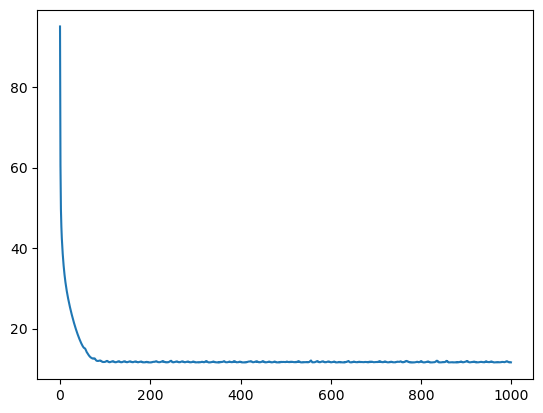

(80, 1) (1,)


In [122]:
# Train your regression model
w, bias = minibatch(train_x, train_y, train_config)
# with open('./model/weight_3.27011.pickle', 'rb') as f:
#     w = pickle.load(f)
# with open('./model/bias_3.27011.pickle', 'rb') as f:
#     bias = pickle.load(f)
print(w.shape, bias.shape)

# **Testing & Write result as .csv**

---



In [123]:
with open('./testing_result/my_sol.csv', 'w', newline='') as csvf:
    # 建立 CSV 檔寫入器
    writer = csv.writer(csvf)
    writer.writerow(['Id','Predicted'])

    print(test_x.shape) 
    for i in range(int(test_x.shape[0])):
      # Prediction of linear regression 
      prediction = (np.dot(np.reshape(w,-1),test_x[i]) + bias)[0]
      writer.writerow([i, prediction] )

# Store parameters
# with open('./model/weight.pickle', 'wb') as f:
#     pickle.dump(w, f)
# with open('./model/bias.pickle', 'wb') as f:
#     pickle.dump(bias, f)

(90, 80)
